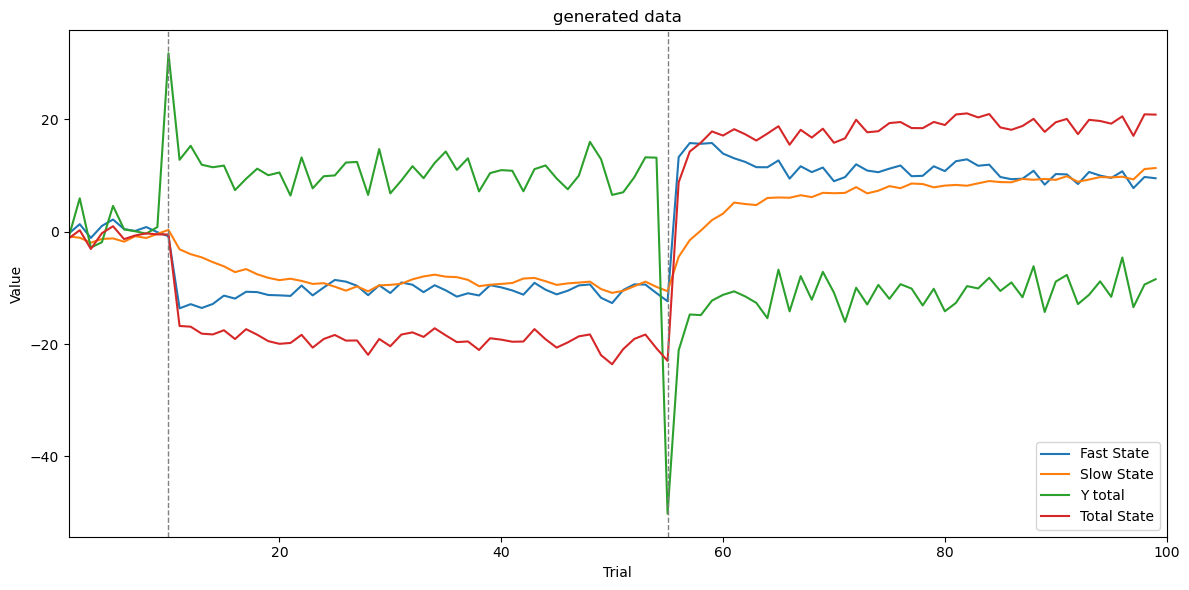

In [2]:
# -*- coding: utf-8 -*-
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from pymc_extras.statespace.core.statespace import PyMCStateSpace
from pymc_extras.statespace.models.utilities import make_default_coords
import pytensor.tensor as pt

# Initialize data
T = 10 + 45 + 45  # total trials = 100
PertSize = np.zeros(T)  # initialize all to 0

# Apply perturbations in degrees
PertSize[10:55] = 30
PertSize[55:100] = -30

#Generate data
A_fast = 0.6
A_slow = 0.9
B_fast = 0.4
B_slow = 0.1

sigma_nu = 0.5
sigma_eta = 2

# initialize
numTrials = T  
x_slow = np.zeros(numTrials)
x_fast = np.zeros(numTrials)
x_total_test = np.zeros(numTrials)
y_obs_test = np.zeros(numTrials)

# noise 
eta_fast = np.random.normal(0, sigma_nu, numTrials)
eta_slow = np.random.normal(0, sigma_nu, numTrials)
eps = np.random.normal(0, sigma_eta, numTrials)

# step 0
x_fast[0] = eta_fast[0]
x_slow[0] = eta_slow[0]
x_total_test[0] = x_slow[0] + x_fast[0]
y_obs_test[0] = x_fast[0] + x_slow[0] + PertSize[0] + eps[0]

# update
for t in range(numTrials - 1):
    x_slow[t + 1] = A_slow * x_slow[t] - B_slow * y_obs_test[t] + eta_slow[t + 1]
    x_fast[t + 1] = A_fast * x_fast[t] - B_fast * y_obs_test[t] + eta_fast[t + 1]
    x_total_test[t + 1] = x_slow[t + 1] + x_fast[t + 1]
    y_obs_test[t + 1] = x_total_test[t + 1] + PertSize[t + 1] + eps[t + 1]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x_fast, label="Fast State", color="tab:blue")
plt.plot(x_slow, label="Slow State", color="tab:orange")
plt.plot(y_obs_test, label="Y total", color="tab:green")
plt.plot(x_total_test, label="Total State", color="tab:red")

# 添加竖直线
for vline in [10, 55]:
    plt.axvline(x=vline, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Trial")
plt.xlim(1, 100)
plt.ylabel("Value")
plt.title("generated data")
plt.legend()
plt.tight_layout()
plt.show()

In [234]:
y_obs_test_nan_append = np.append(np.nan,y_obs_test[0:99])
Y = y_obs_test_nan_append.reshape(-1, 1)
len(Y)

100

In [3]:
### Two rate model class
class TwoState1SubjectModel(PyMCStateSpace):
    def __init__(self, n_timesteps=T, psize=PertSize):
        k_states = 3  # size of the state vector x
        k_posdef = 3  # number of shocks (size of the state covariance matrix Q)
        k_endog = 1  # number of observed states
        
        self.n_timesteps = n_timesteps
        self.psize = psize
        
        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)
    
    def make_symbolic_graph(self):
        # Declare symbolic variables that represent parameters of the model
        x0 = self.make_and_register_variable("x0", shape=(3,))
        P0 = self.make_and_register_variable("P0", shape=(3, 3))
        Af = self.make_and_register_variable("Af", shape=()) #Afast, Aslow
        As = self.make_and_register_variable("As", shape=())
        Bf = self.make_and_register_variable("Bf", shape=()) #Bfast, Bslow
        Bs = self.make_and_register_variable("Bs", shape=())
        sigma_nu = self.make_and_register_variable("sigma_nu", shape=()) #sigma_fast
        sigma_eta = self.make_and_register_variable("sigma_eta", shape=()) #sigma_y
        
        # Next, use these symbolic variables to build the statespace matrices by assigning each parameter
        # to its correct location in the correct matrix
        self.ssm["initial_state", :] = x0
        self.ssm["initial_state_cov", :, :] = P0

        self.ssm["transition", :, :] = pt.stack([
            pt.stack([Af, 0, -Bf]),
            pt.stack([0, As, -Bs]),
            pt.stack([Af, As, -Bf-Bs])
        ])

        self.ssm["selection", :, :] = pt.stack([
            pt.stack([1.0, 0, 0]),
            pt.stack([0, 1, 0]),
            pt.stack([1, 1, 1])
        ])

        self.ssm["state_cov", :, :] = pt.stack([
            pt.stack([sigma_nu*sigma_nu, 0.0, 0]),
            pt.stack([0, sigma_nu*sigma_nu, 0]),
            pt.stack([0.0, 0.0, sigma_eta*sigma_eta])
        ])

        state_intercept = pt.zeros((self.n_timesteps, self.k_states))
        state_intercept = state_intercept[:, 2].set(self.psize)
        self.ssm["state_intercept"] = state_intercept

        self.ssm["design", :, :] = np.array([[0, 0, 1]])

    @property
    def param_names(self):
            return ["x0", "P0", "Af", "As", "Bf", "Bs", "sigma_nu", "sigma_eta"]
     
    @property
    def state_names(self):
        return ["Xf", "Xs", "Yfs"]
    
    @property
    def observed_states(self):
        return ["handerror"]
    
    @property
    def shock_names(self):
        return ["nu_f", "nu_s", "eta"]

In [10]:
# Build two rate model
tsm = TwoState1SubjectModel(n_timesteps=T, psize=PertSize)
coords = make_default_coords(tsm)
y_obs_test_nan_append = np.append(0,y_obs_test[0:99])
Y = y_obs_test_nan_append.reshape(-1, 1)

with pm.Model(coords=coords) as mod:
    x0 = pm.Data("x0", np.zeros(3, dtype="float"))
    P0 = pm.Data("P0", np.eye(3) * 1)
    # ---------- A parameters -------
    imAf_logit = pm.Normal("imAf_logit", mu=-0.4, sigma=0.15)  
    imAf = pm.Deterministic("imAf", pm.math.sigmoid(imAf_logit)) # Centered around sigmoid(-0.4) ≈ 0.4 = imAf
    Af = pm.Deterministic("Af", 1.0 - imAf)                      # Af = 0.6

    imAs1_logit = pm.Normal("imAs1_logit", mu=0, sigma=0.5)
    imAs1 = pm.Deterministic("imAs1", pm.math.sigmoid(imAs1_logit)) # Centered around sigmoid(0) ≈ 0.5 = imAs1
    As = pm.Deterministic("As", 1.0 - imAf * imAs1)  #  As > Af 
    # ---------- B parameters -------
    Bf_logit = pm.Normal("Bf_logit", mu=-1.5, sigma=0.5)  # -2 < Bf_logit < -1
    Bf = pm.Deterministic("Bf", pm.math.sigmoid(Bf_logit)) # 0.12 < Bf < 0.27   

    Bs1_logit = pm.Normal("Bs1_logit", mu=-1.7, sigma=0.5)  # -2 < Bs1_logit < 0
    Bs_logit = pm.Deterministic("Bs_logit", Bf_logit + Bs1_logit )                  # Bs_logit < Bf_logit
    Bs = pm.Deterministic("Bs", pm.math.sigmoid(Bs_logit)) # Bs < Bf
    
    # ---------- noise -------
    sigma_nu = pm.Gamma("sigma_nu", mu=0.5, sigma=0.25)
    sigma_eta = pm.Gamma("sigma_eta", mu=2, sigma=1)
    
    tsm.build_statespace_graph(data = Y)

c:\Users\899003\GitHub\state-space-models\.pixi\envs\default\Lib\site-packages\pymc_extras\statespace\utils\data_tools.py:74: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)


In [11]:
prior_checks = pm.sample_prior_predictive(samples=1000, model=mod)

Sampling: [Bf_logit, Bs1_logit, imAf_logit, imAs1_logit, obs, sigma_eta, sigma_nu]


array([[<Axes: title={'center': 'Af'}>, <Axes: title={'center': 'As'}>,
        <Axes: title={'center': 'Bf'}>],
       [<Axes: title={'center': 'Bs'}>,
        <Axes: title={'center': 'sigma_nu'}>,
        <Axes: title={'center': 'sigma_eta'}>]], dtype=object)

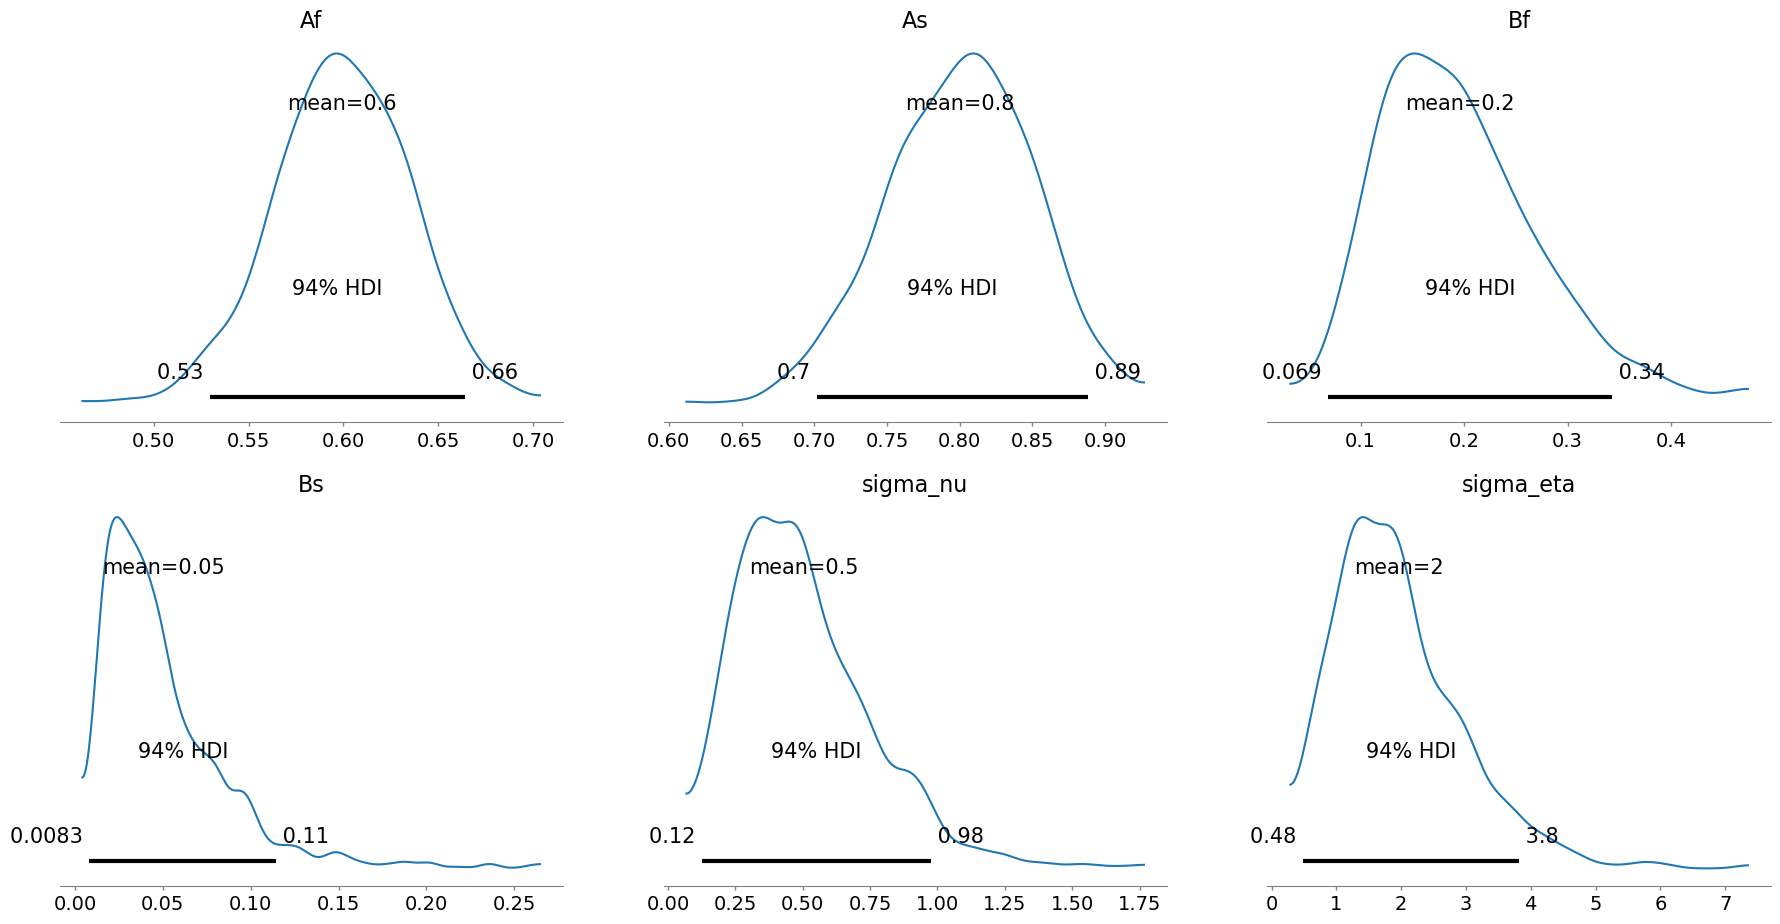

In [12]:
az.plot_posterior(prior_checks, var_names=["Af", "As", "Bf", "Bs", "sigma_nu","sigma_eta"], group="prior")

array([[<Axes: title={'center': 'imAf_logit'}>,
        <Axes: title={'center': 'imAf'}>,
        <Axes: title={'center': 'imAs1_logit'}>],
       [<Axes: title={'center': 'imAs1'}>,
        <Axes: title={'center': 'Bf_logit'}>,
        <Axes: title={'center': 'Bs1_logit'}>],
       [<Axes: title={'center': 'Bs_logit'}>, <Axes: >, <Axes: >]],
      dtype=object)

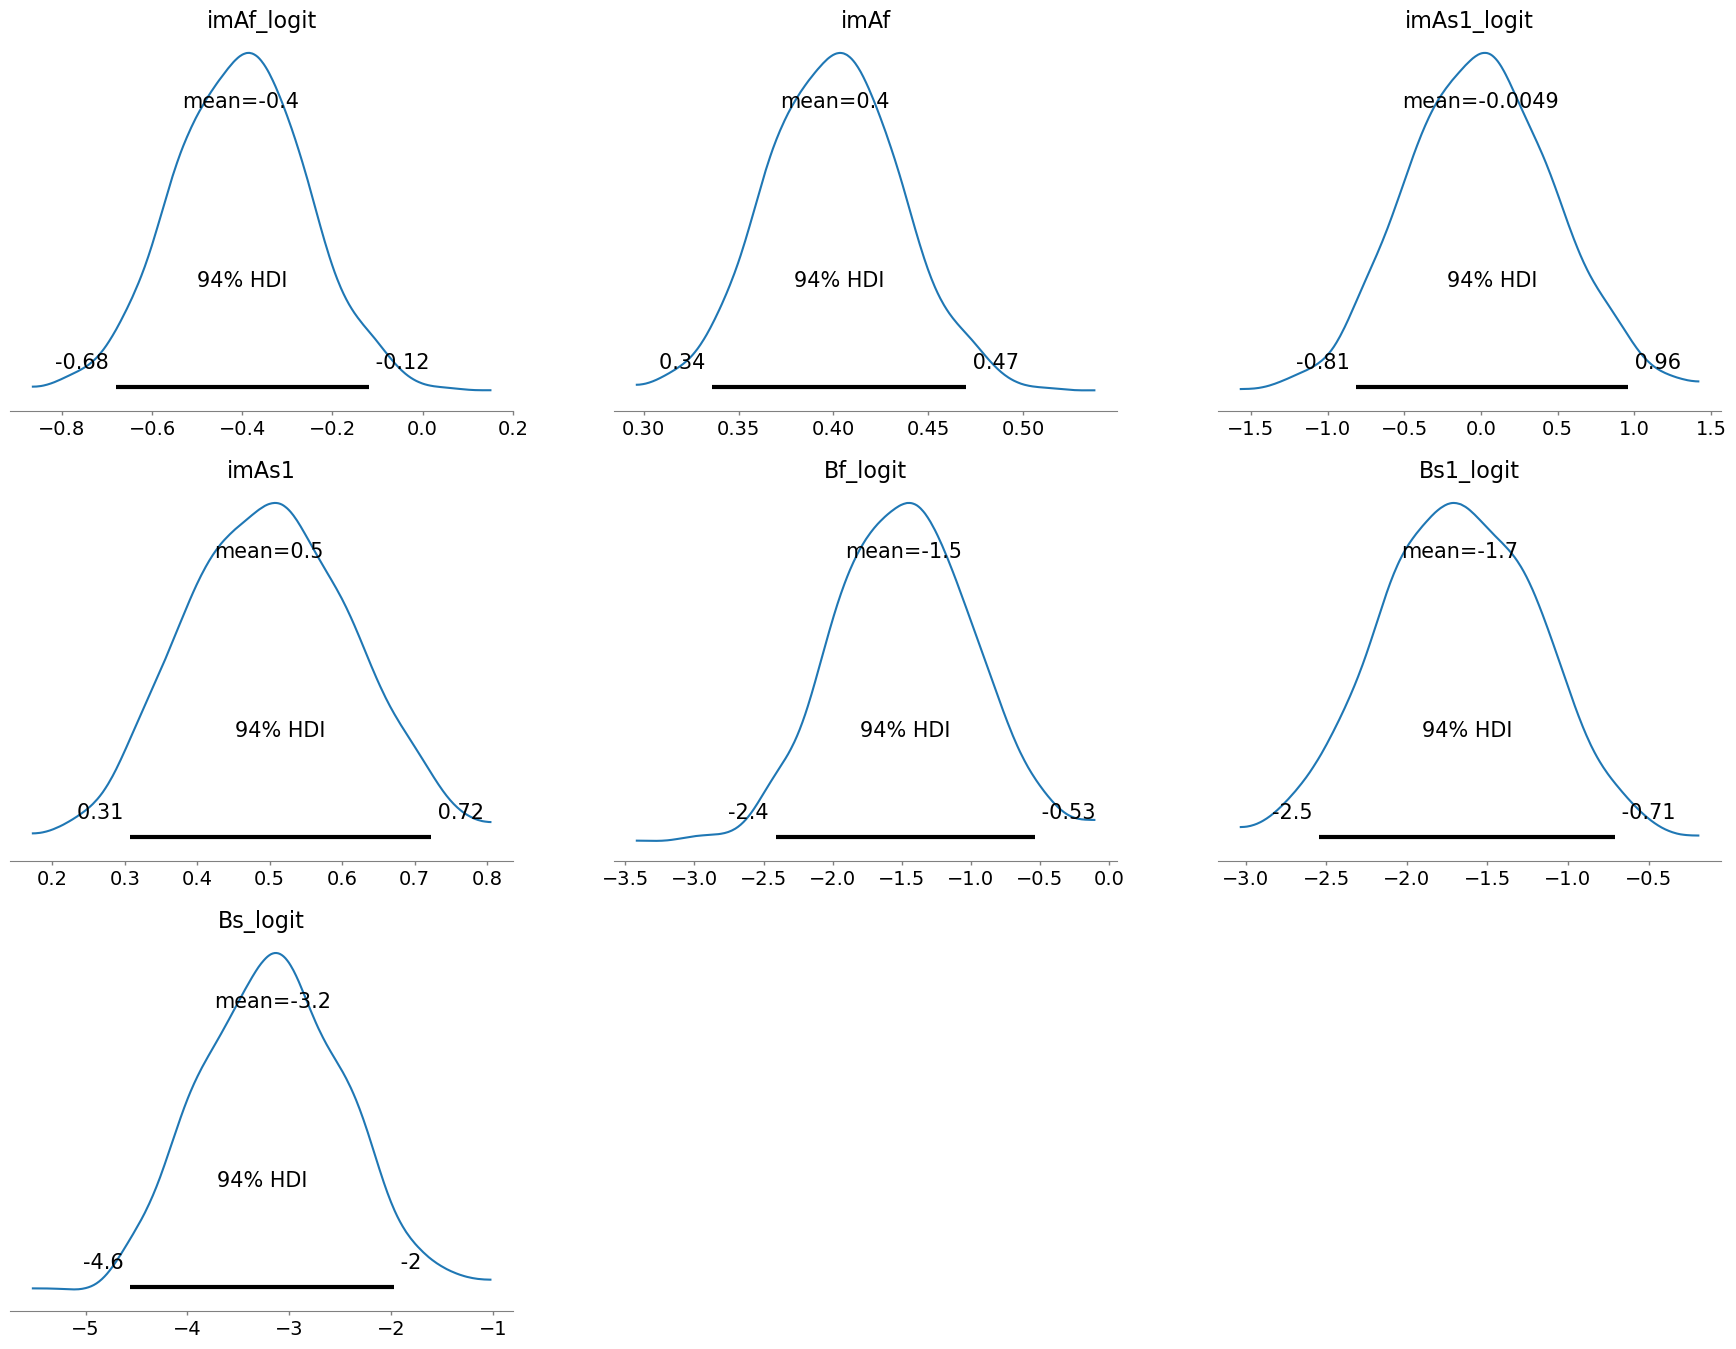

In [13]:
az.plot_posterior(prior_checks, var_names=["imAf_logit", "imAf", "imAs1_logit", "imAs1", "Bf_logit", "Bs1_logit", "Bs_logit"], group="prior")

array([<Axes: title={'center': 'sigma_nu'}>,
       <Axes: title={'center': 'sigma_eta'}>], dtype=object)

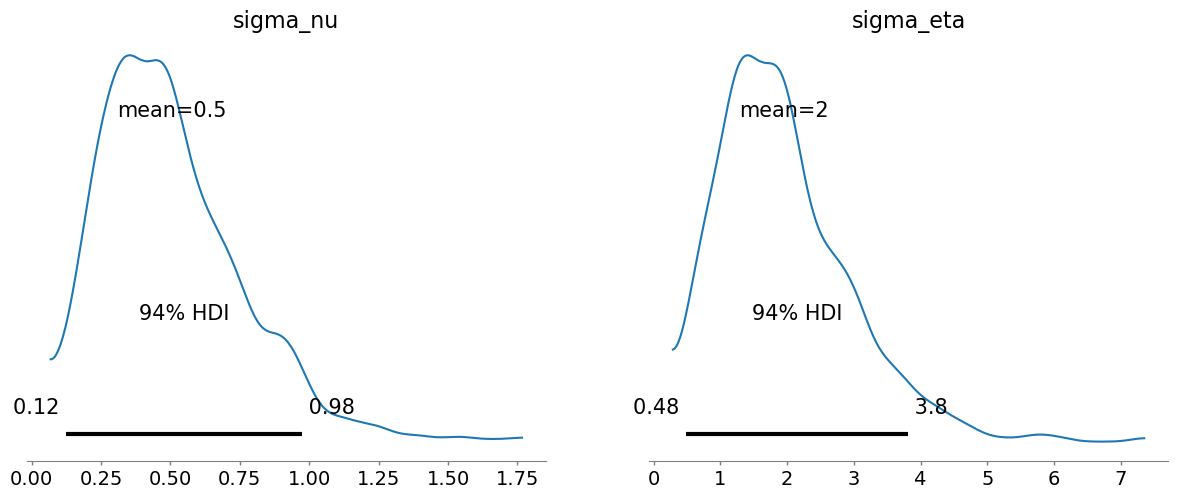

In [14]:
az.plot_posterior(prior_checks, var_names=["sigma_nu", "sigma_eta"], group="prior")

<Axes: xlabel='obs'>

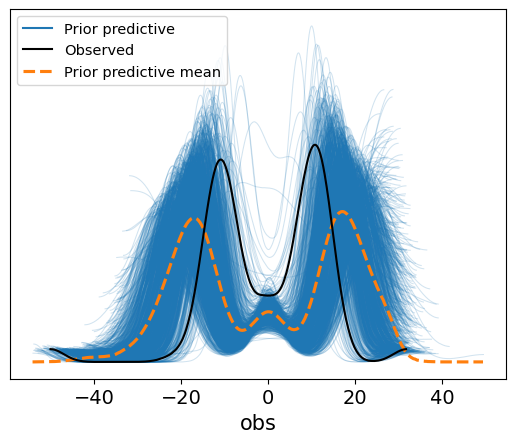

In [15]:
az.plot_ppc(prior_checks, observed=True, group="prior")

In [16]:
idata = pm.sample(1000, tune=1000, target_accept=0.95, model=mod, nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"});

c:\Users\899003\GitHub\state-space-models\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Error updating progress display: <ContextVar name='parent_header' at 0x0000028A42243E70>
Error updating progress display: <ContextVar name='parent_header' at 0x0000028A42243E70>
Error updating progress display: <ContextVar name='parent_header' at 0x0000028A42243E70>
Error updating progress display: <ContextVar name='parent_header' at 0x0000028A42243E70>
Error updating progress display: <ContextVar name='parent_header' at 0x0000028A42243E70>
Error updating progress display: <ContextVar name='parent_header' at 0x0000028A42243E70>
Error updating progress display: <ContextVar name='parent_header' at 0x0000028A42243E70>
Error updating progress display: <ContextVar name='parent_header' at 0x0000028A42243E70>
Error updating progress display: <ContextVar name='parent_header' at 0x0000028A42243E70>
Error updating progress display: <ContextVar name='parent_header' at 0x0000028A42243E70>
Error updating progress display: <ContextVar name='parent_header' at 0x0000028A42243E70>
Error updating progre

In [19]:
pm.sample_posterior_predictive(idata, model=mod, extend_inferencedata=True);

Sampling: [obs]


Output()

In [17]:
var_names=["Af", "As", "Bf", "Bs", "sigma_eta", "sigma_nu"]

In [18]:
az.summary(data=idata, var_names=var_names, round_to=2, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Af,0.62,0.03,0.56,0.68,0.0,0.0,1530.44,1755.07,1.0
As,0.85,0.02,0.82,0.89,0.0,0.0,1191.04,2025.87,1.0
Bf,0.34,0.04,0.26,0.41,0.0,0.0,766.94,991.71,1.0
Bs,0.14,0.03,0.08,0.21,0.0,0.0,775.25,1031.86,1.0
sigma_eta,2.10,0.20,1.70,2.48,0.0,0.0,3923.73,2662.04,1.0
sigma_nu,0.52,0.16,0.21,0.84,0.0,0.0,3242.25,2358.53,1.0


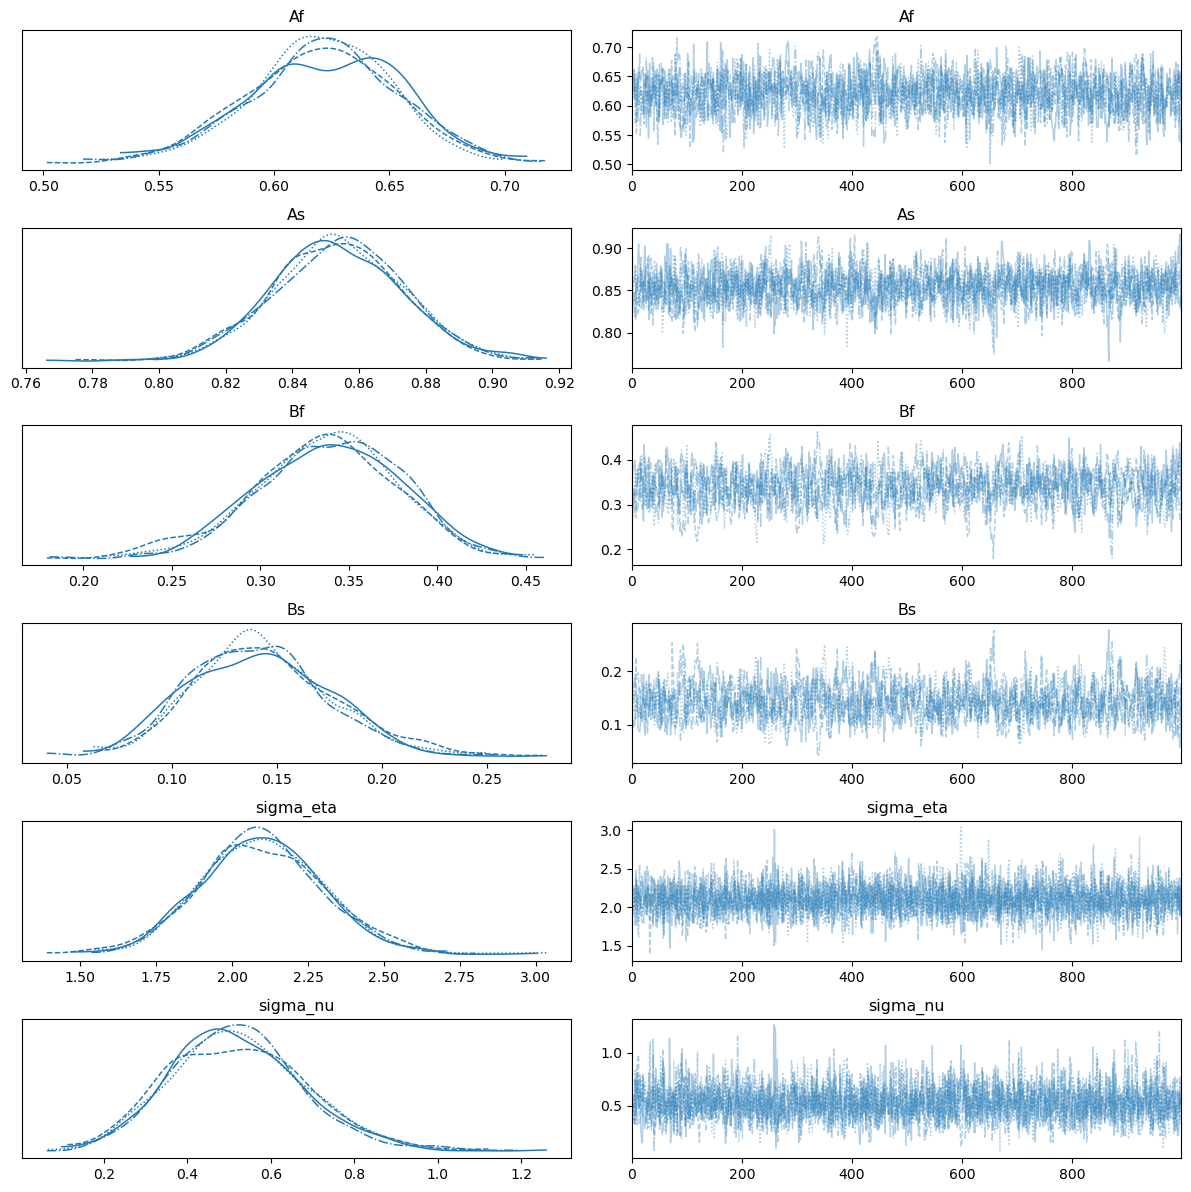

In [20]:
az.plot_trace(idata, var_names=var_names);
plt.tight_layout(pad=1.0)
plt.show()

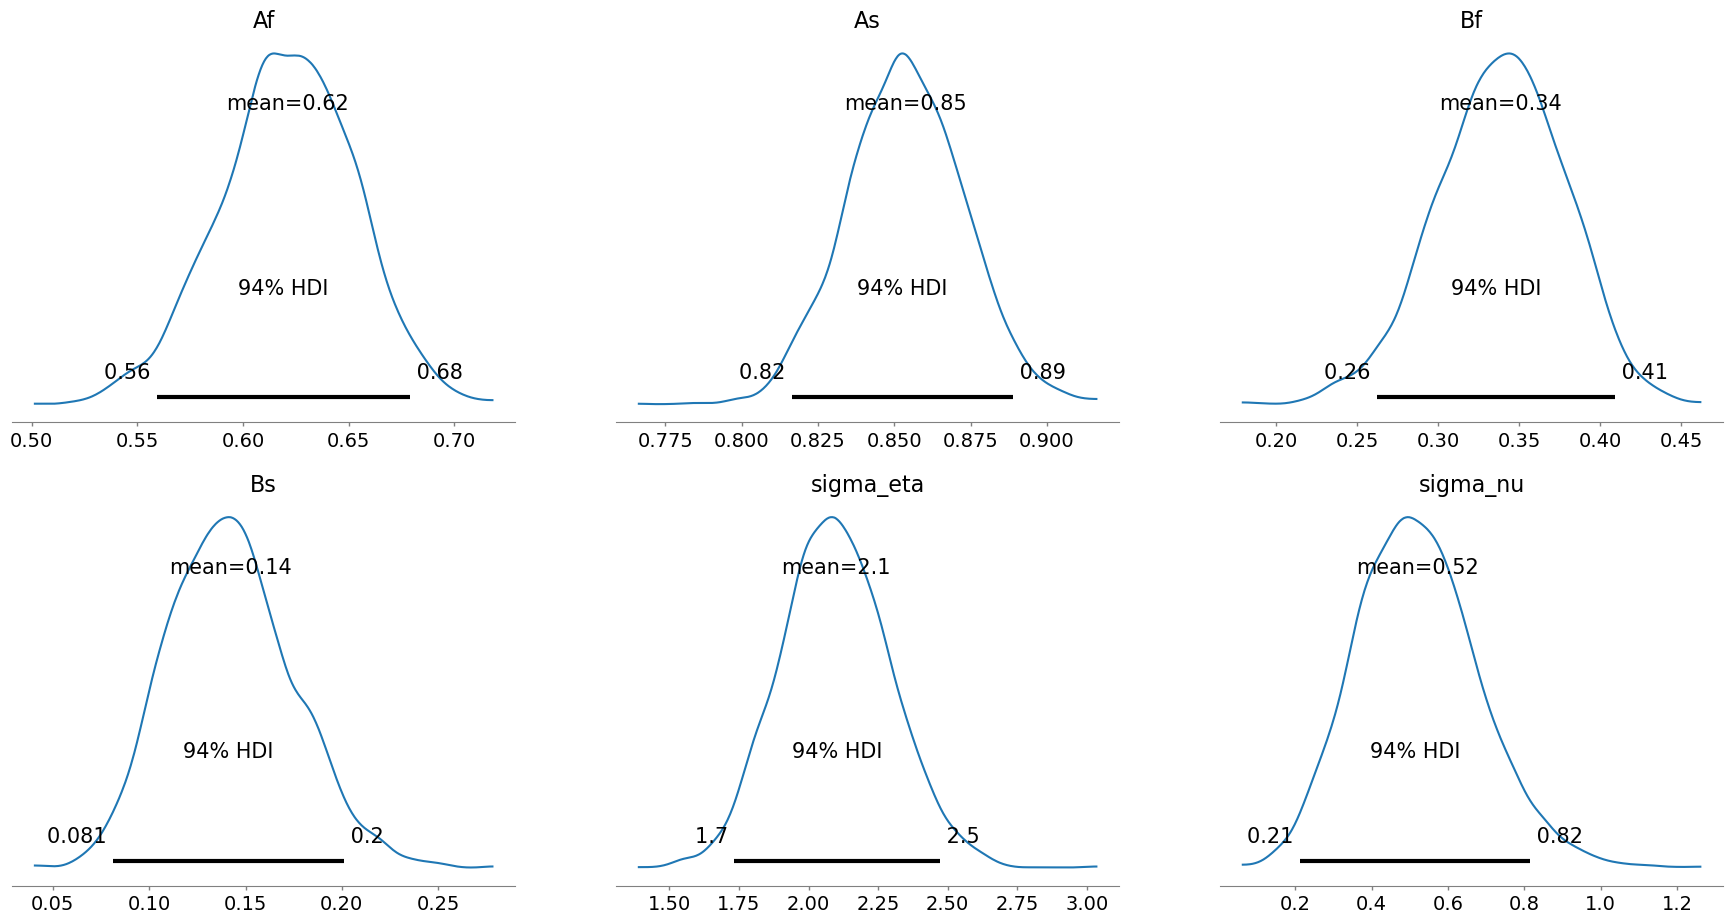

In [21]:
az.plot_posterior(idata, var_names=var_names);

In [22]:
az.to_netcdf(idata, "Output/model2state1subj.nc")

'Output/model2state1subj.nc'

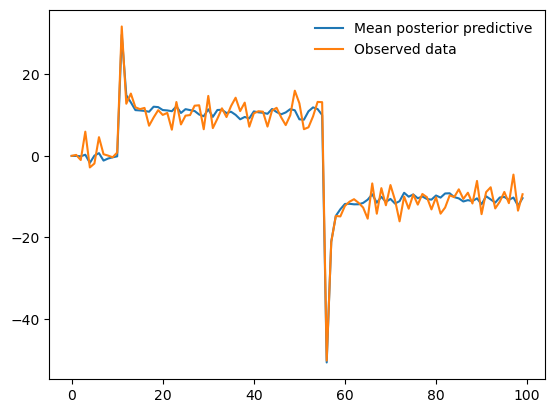

In [23]:
idata.posterior_predictive['obs'].mean(['chain','draw'])
fig = plt.figure()
plt.plot(idata.posterior_predictive['time'],idata.posterior_predictive['obs'].mean(['chain','draw']),label='Mean posterior predictive')
plt.plot(Y,label='Observed data')
plt.legend(frameon = False)

